<a href="https://colab.research.google.com/github/IgnacioPardo/SNN/blob/main/SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Network

Simple Red Neuronal (Perceptrón) para la materia Tecnologías Exponenciales - TIC

Inspirado en https://github.com/jonasbostoen/simple-neural-network

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import networkx as nx
from random import random as rand
import itertools

In [2]:
np.random.seed(1)

### Funciones

In [3]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

# sigmoid = lambda x : 1 / ( 1 + np.exp(-x) )

def sigmoid_derivative(x):
    return x * (1 - x)

# sigmoid_derivative = lambda x : x * (1 - x)

Las funciones de activación se usan para sacarle la linealidad a la red neuronal y normalizar los valores de salida de una neurona entre 0 y 1, y a partir de un threshold decidir si la neurona está "prendida" o no.

Sigmoid Function
$$\operatorname{f}(x)=\frac{1}{1+e^{(-x)}}$$
Esta es la función de activación de la capa de output.

Sigmoid Derivative Function
$$\operatorname{f'}(x)=x \times (1-x)$$

#### Visualización Función Sigmoide

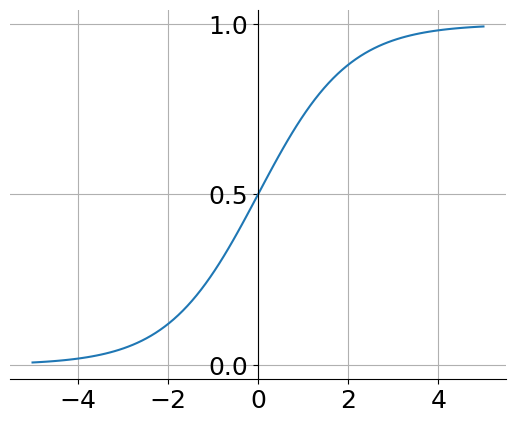

In [4]:
x = np.linspace(-5,5,100)
y = sigmoid(x)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.plot(x, y)
plt.locator_params(axis='y', nbins=3)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid()

## Setup

### Values

#### Training Values

In [5]:
dataset = pd.read_csv('champs.csv')
dataset.pop('regions') # Unused column
display(dataset)

# Split comas into arrays of string in 'positions' and 'range_type' columns
dataset['positions'] = dataset['positions'].apply(lambda x: x.split(','))
dataset['range_type'] = dataset['range_type'].apply(lambda x: x.split(','))

# Label encode for 'gender' column
unique_categories = dataset['gender'].unique()
category_to_code = {category: code for code, category in enumerate(unique_categories)}
display(category_to_code)
dataset['gender'] = dataset['gender'].map(category_to_code)

# One-hot encode for 'positions' and 'range_type' columns
# 'positions'
dataset = dataset.explode('positions')
one_hot_encoded = pd.get_dummies(dataset, columns=['positions'], prefix='positions').astype(int, errors='ignore')
dataset = one_hot_encoded.groupby(level=0).max()
# 'range_type'
dataset = dataset.explode('range_type')
one_hot_encoded = pd.get_dummies(dataset, columns=['range_type'], prefix='range_type').astype(int, errors='ignore')
dataset = one_hot_encoded.groupby(level=0).max()

# In column 'name', join in an array all the names where the other columns match
dataset = dataset.groupby(dataset.columns.difference(['name']).tolist(), as_index=False).agg(lambda x: x.tolist())

# Move 'name' column to the left-most position
name_col = dataset.pop('name')
dataset.insert(0, 'name', name_col)

display(dataset)

# One-hot encode for 'name' column
dataset = dataset.explode('name')
one_hot_encoded = pd.get_dummies(dataset, columns=['name'], prefix='name').astype(int, errors='ignore')
dataset = one_hot_encoded.groupby(level=0).max()

dataset

,name,gender,positions,range_type
0,Aatrox,Male,Top,Melee
1,Ahri,Female,Middle,Ranged
2,Akali,Female,"Middle,Top",Melee
3,Akshan,Male,"Middle,Top",Ranged
4,Alistar,Male,Support,Melee
...,...,...,...,...
159,Zeri,Female,Bottom,Ranged
160,Ziggs,Male,"Bottom,Middle",Ranged
161,Zilean,Male,Support,Ranged
162,Zoe,Female,Middle,Ranged


{'Male': 0, 'Female': 1, 'Other': 2}

,name,gender,positions_Bottom,positions_Jungle,positions_Middle,positions_Support,positions_Top,range_type_Melee,range_type_Ranged
0,"[Kennen, Teemo, Urgot]",0,0,0,0,0,1,0,1
1,"[Aatrox, Cho'Gath, Darius, Dr. Mundo, Gangplan...",0,0,0,0,0,1,1,0
2,[Gnar],0,0,0,0,0,1,1,1
3,"[Bard, Brand, Milio, Zilean]",0,0,0,0,1,0,0,1
4,"[Alistar, Braum, Nautilus, Pyke, Rakan, Taric,...",0,0,0,0,1,0,1,0
5,[Tahm Kench],0,0,0,0,1,1,1,0
6,"[Aurelion Sol, Azir, Corki, Malzahar, Twisted ...",0,0,0,1,0,0,0,1
7,"[Fizz, Kassadin, Sylas, Yasuo, Zed]",0,0,0,1,0,0,1,0
8,"[Akshan, Ryze]",0,0,0,1,0,1,0,1
9,"[Rumble, Yone]",0,0,0,1,0,1,1,0


,gender,positions_Bottom,positions_Jungle,positions_Middle,positions_Support,positions_Top,range_type_Melee,range_type_Ranged,name_Aatrox,name_Ahri,...,name_Yone,name_Yorick,name_Yuumi,name_Zac,name_Zed,name_Zeri,name_Ziggs,name_Zilean,name_Zoe,name_Zyra
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
# Training inputs variable that's an np array of all columns except the ones prefixed with 'name_'
training_inputs = np.array(dataset.drop(dataset.filter(regex='name_'), axis=1))

training_outputs = np.array(dataset.filter(regex='name_'))

display(training_inputs)
display(training_outputs)

array([[0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0, 1],
       [1,

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
training_values = np.concatenate((training_inputs.T, training_outputs.T)).T
table = lambda arr : display(HTML(tabulate.tabulate(arr, tablefmt='html')))
table(training_values)

0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Synaptic weights 

In [7]:
n = training_inputs.shape[1]
display(training_inputs.shape)
synaptic_weights = 2 + np.random.random((n, 164)) - 1

synaptic_weights

(41, 8)

array([[1.417022  , 1.72032449, 1.00011437, ..., 1.49376971, 1.61995572,
        1.8289809 ],
       [1.15679139, 1.0185762 , 1.07002214, ..., 1.47714099, 1.15267164,
        1.62180623],
       [1.54401012, 1.65413735, 1.14454554, ..., 1.31144421, 1.5172676 ,
        1.91640585],
       ...,
       [1.68849732, 1.25339603, 1.69236012, ..., 1.09410027, 1.87019175,
        1.2368687 ],
       [1.38600401, 1.57154209, 1.52580197, ..., 1.7043134 , 1.68164534,
        1.69714853],
       [1.61860074, 1.15098073, 1.76080246, ..., 1.68895505, 1.40400161,
        1.13611315]])

## Training

Para obtener un resultado a partir de los inputs y los synaptic weights se realiza la siguiente función:

$$\sum_{i=0}^{n}{x_iw_i}$$

Y se le aplica la función sigmoide para normalizar al rango 0, 1

Por ejemplo, si nuestros inputs $x_i$ son `[1, 1, 1]` y nuestros pesos sinapticos $w_i$ son `[[11.30926442], [-0.20511667], [-5.4500033]]`

Nos resulta la cuenta
$$[1 \times 11.30926442] + [1 \times (-0.20511667)] + [1 \times (-5.4500033)] = 5.6541444499999995$$

Con la función sigmoide es facil ver como $$\operatorname{sigmoid}(5.65) \approx 1$$

In [8]:
eval_NN = lambda x, w: sigmoid(np.dot(x, w))

In [9]:
# 50000 epochs
for iteration in range(50000):

    # Arranca con los valores de training
    input_layer = training_inputs

    # Genera un output haciendo la suma de los valores de input multiplicados por su peso sinaptico, y aplicandole la función sigmoide para normalizar a -1, 1
    outputs = eval_NN(input_layer, synaptic_weights)

    # Calculo el error
    error = training_outputs - outputs

    # Ajusto los pesos en funcion al error y al resultado obtenido
    adjustments = error * sigmoid_derivative(outputs)
    synaptic_weights += np.dot(input_layer.T, adjustments)

En este pedazo de código podemos ver 3 conceptos diferentes: Forwards Propagation, Backwards Propagation y Gradient Descent.

### Forwards Propagation

Primero vemos como se calculan los outputs de la red neuronal al aplicarle los weights a los inputs; los datos van pasando del inicio, pasando por cada capa (aunque en este caso solo pasa de input a output sin hidden layers) y transformandose hasta llegar al final.

### Backwards Propagation

Luego vemos como se calcula el error de estos primeros outputs con respecto a los valores reales, y se hace un ajuste para propagar el error para atras, cambiando los weights para que en el proximo epoch el error sea menor.

### Gradient Descent

Y esas dos propagaciones forman el Gradient Descent, algoritmo que mediante iteraciones, ir haciendo ajustes a los weights para encontrar para que valor de weights el error sea el mínimo, como mostraste el grafiquito en clase que intenta bajar la pendiente.

In [10]:
print('Synaptic weights after training')
print(synaptic_weights)

print('Outputs after training: ')
print(outputs)

Synaptic weights after training
[[ -9.95377677   8.84497396   8.63331372 ... -10.15518153   8.84296191
    8.37977652]
 [ -0.422163    -6.545014    -1.48034344 ...  -5.14511991  -6.43818111
   -9.5046679 ]
 [ -9.95492403 -14.92528629  -2.74971188 ...  -5.14513203 -14.81648064
  -16.1732415 ]
 ...
 [  2.90285819  -6.54508014   8.63821801 ...  -5.14539842  -6.43824305
   -8.15222428]
 [  1.65649325 -17.2800981  -21.8307944  ... -10.75480296 -17.3818465
  -23.00477004]
 [ -9.97798953  -7.89369754 -22.7611857  ...  -0.59840838  -7.99747518
   -5.625933  ]]
Outputs after training: 
[[8.45179416e-04 5.36206049e-07 7.35336738e-07 ... 3.19236218e-03
  5.37849090e-07 1.03809091e-06]
 [9.89639510e-01 4.49654487e-11 1.86444524e-06 ... 1.24349336e-07
  4.51948516e-11 2.94253006e-14]
 [4.41365723e-03 1.67763360e-14 2.42949310e-16 ... 6.83530694e-08
  1.51997732e-14 1.06026396e-16]
 ...
 [6.87161268e-14 2.29404839e-07 1.09748507e-08 ... 2.64909247e-05
  2.30164129e-07 4.40334785e-03]
 [5.62756936e-1

## Eval

In [13]:
table(training_values)

0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
large = lambda x : display(HTML('<p style="font-size: 50px; color: #66D148">'+str(x)+'</p>'))

In [16]:
gender = 0 #@param {type:"integer"} # {'Male': 0, 'Female': 1, 'Other': 2}
is_bottom = 0 #@param {type:"integer"}
is_jungle = 0 #@param {type:"integer"}
is_middle = 0 #@param {type:"integer"}
is_support = 1 #@param {type:"integer"}
is_top = 0 #@param {type:"integer"}
is_melee = 1 #@param {type:"integer"}
is_ranged = 0 #@param {type:"integer"}

input_layer = np.array([gender, is_bottom, is_jungle, is_middle, is_support, is_top, is_melee, is_ranged])
res = sigmoid(np.dot(input_layer, synaptic_weights))

thresh = 0.02
out = (res >= thresh).astype(int)

# Get the names of the champions that match the output
champions = dataset.filter(regex='name_').columns
champions = champions[out == 1]
champions = champions.tolist()
champions = [champion[5:] for champion in champions]

large(champions)

### Graph

No pude hacer andar el graph para mostrarlo, e igual no creo que se haya visto bien por la cantidad de neuronas que tiene.

La estructura de red tiene 2 capas. La primera es de inputs con 8 neuronas, una representando el género del campeón, otras 5 representando las posiciones en las que se juega el campeón y unas últimas 2 representando el tipo de ataque del campeón. La segunda capa es de outputs y cuenta con 164 neuronas, una para cada campeón. Eso dejaría un total de 1312 weights entre las dos capas.

## Bonus

A. **¿Como modificarían la estructura de la red para que admita $k$ capas ocultas con $n$ neuronas cada una? Describir como sería el algoritmo de forward propagation en este caso, no es necesario implementar el algoritmo de back propagation.**

A los inputs se los multiplicaría por la cantidad de weights necesaria siendo l la cantidad de inputs, l*n. Esa primera capa de outputs se le entrega a la capa k subindice 0 de neuronas, se aplicaría la función de activación y se volvería a multipliciar por weights para la siguiente capa y así. El algoritmo de forward propagation sería el mismo, solo que se le agregaría un for para recorrer las hidden layers. 

B. **Investigar la función de activación Softmax y explicar como se puede utilizar para resolver un problema de clasificación con $m$ clases mutualmente excluyentes. ¿Que habría que modificar en el código para utilizar esta función de activación?**

La función Softmax, es parecida a ReLU, y difiere de la sigmoide en que los valores son proporcionales, entonces cuando el valor de una neurona aumenta, el del resto disminuye, disparandose la función hacia +infinito, lo que la hace perfecta para clasificación de clases mutuamente excluyentes, tomando solo la neurona con valor más alto como final. Para implementarla se debería definir como:
```python
    def softmax(x) = np.exp(x)/sum(np.exp(x))
```
según lo que encontramos en la documentación de scipy y stack overflow. Después habría que cambiar Eval_NN para que use softmax en vez de sigmoid, y por último a la hora de predecir en res.